## Example 1: Multiple linear regression

Import libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib.lines import Line2D

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)
plt.rcParams['figure.dpi'] = 300

Load data

In [3]:
data = bmb.load_data("ESCS")

Initialize and fit model

In [4]:
model = bmb.Model("drugs ~ o + c + e + a + n", data)
idata = model.fit(draws=2000, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drugs_sigma, n, a, e, c, o, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


Inspect model

In [5]:
model

Formula: drugs ~ o + c + e + a + n
Family name: Gaussian
Link: identity
Observations: 604
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 2.2101, sigma: 21.1938)
    o ~ Normal(mu: 0.0, sigma: 0.0768)
    c ~ Normal(mu: 0.0, sigma: 0.0868)
    e ~ Normal(mu: 0.0, sigma: 0.0816)
    a ~ Normal(mu: 0.0, sigma: 0.0973)
    n ~ Normal(mu: 0.0, sigma: 0.0699)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.6482)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Plot model priors

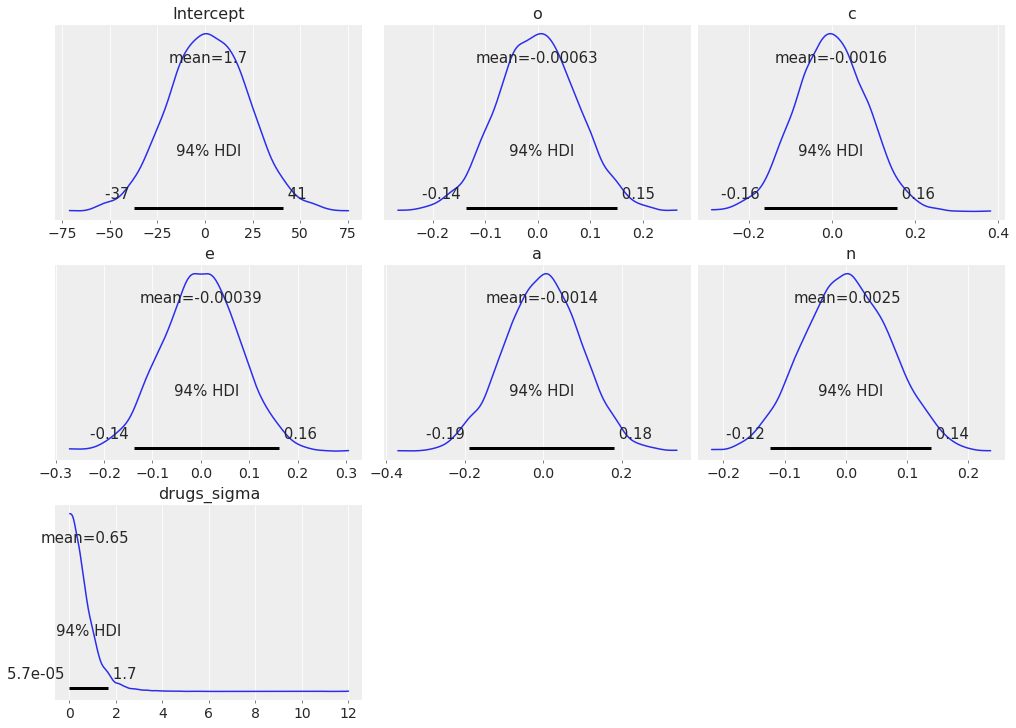

In [6]:
model.plot_priors(figsize = (14, 10));
plt.savefig("imgs/drugs_prior.pdf")

Inspection of InferenceData object

In [7]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Numerical summary of the posterior with diagnostics

In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.303,0.353,2.661,3.977,0.004,0.003,7704.0,6618.0,1.0
o,0.006,0.001,0.004,0.008,0.000,0.000,9431.0,7101.0,1.0
c,-0.004,0.001,-0.007,-0.001,0.000,0.000,7693.0,7147.0,1.0
e,0.003,0.001,0.001,0.006,0.000,0.000,9020.0,6377.0,1.0
a,-0.012,0.001,-0.015,-0.010,0.000,0.000,8684.0,6913.0,1.0
n,-0.002,0.001,-0.004,0.001,0.000,0.000,7369.0,6199.0,1.0
drugs_sigma,0.592,0.017,0.559,0.624,0.000,0.000,9081.0,6457.0,1.0


Density estimates and traceplots of marginal posteriors

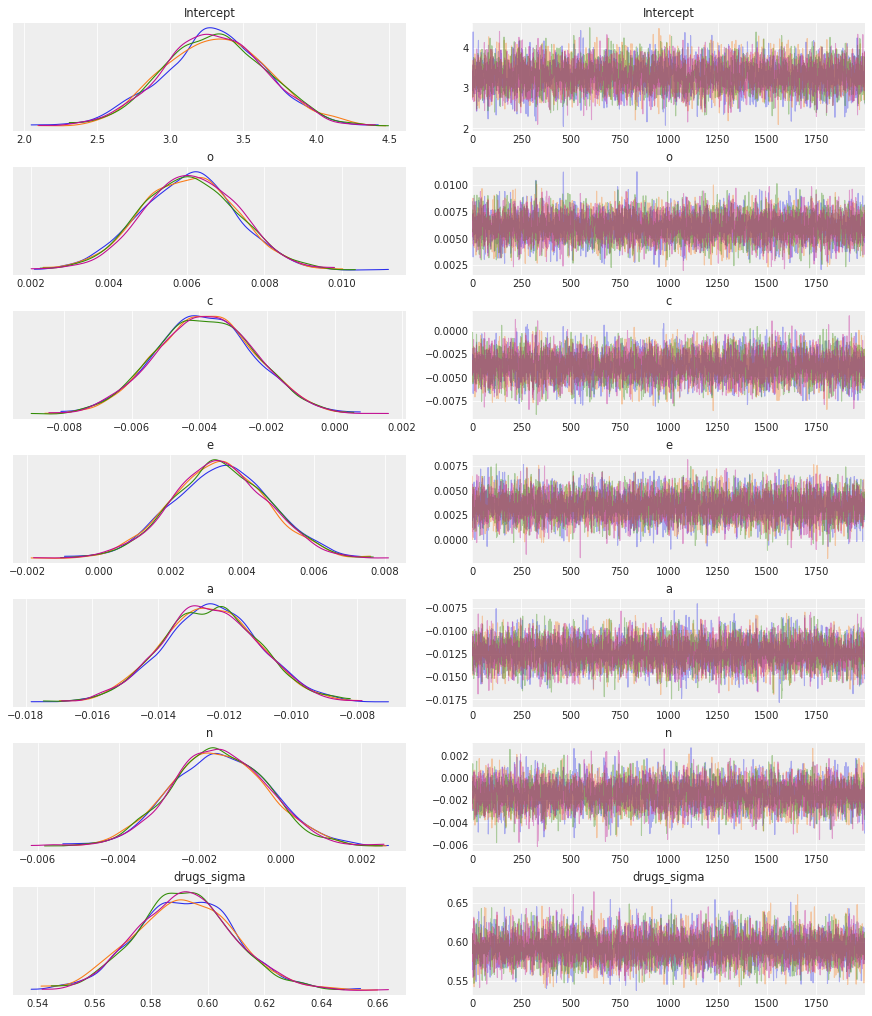

In [9]:
az.plot_trace(idata, compact=False);
plt.savefig("imgs/drugs_posterior.pdf")

Summarize effects on partial correlation scale. First we compute some statistics.

In [10]:
# Select all terms but the Intercept
terms = [t for t in model.common_terms.values() if t.name != "Intercept"]

# Common effects design matrix (excluding intercept/constant term)
x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)

samples = idata.posterior
varnames = ["o", "c", "e", "a", "n"]

# Compute the needed statistics
sd_x = x_matrix.std()
sd_y = data["drugs"].std()
r2_x = pd.Series(
    {
        x: sm.OLS(
            endog=x_matrix[x],
            exog=sm.add_constant(x_matrix.drop(x, axis=1))
        )
        .fit()
        .rsquared
        for x in list(x_matrix.columns)
    }
)
r2_y = pd.Series(
    [
        sm.OLS(
            endog=data["drugs"],
            exog=sm.add_constant(data[[p for p in varnames if p != x]]),
        )
        .fit()
        .rsquared
        for x in varnames
    ],
    index=varnames,
)

# Compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
pcorr_samples = samples[varnames] * slope_constant

In [11]:
labels = [
    "Openness to experience",
    "Conscientiousness",
    "Extraversion",
    "Agreeableness",
    "Neuroticism",
]

/tmp/ipykernel_8385/1403147298.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(bottom=0.1, top=0.925, left=0.026, right=0.99, wspace=0.09)


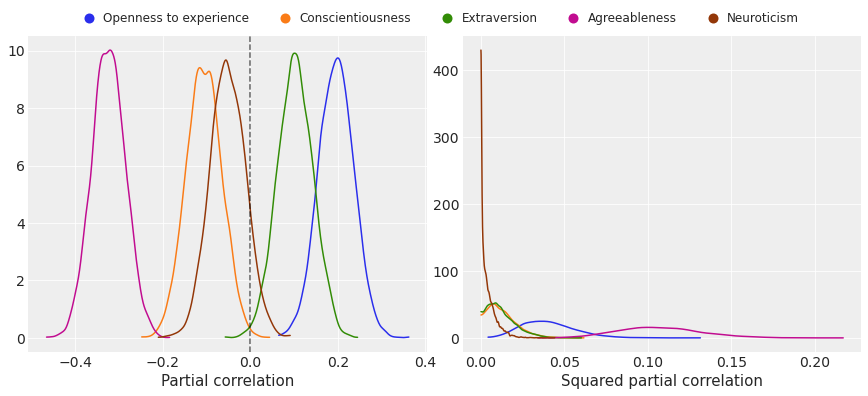

In [12]:
# Pass the same axes to az.plot_kde to have all the densities in the same plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5.33))

for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_kde(np.ravel(v), plot_kwargs={"color": f"C{idx}"}, ax=ax[0])
    az.plot_kde(np.ravel(v) ** 2, plot_kwargs={"color": f"C{idx}"}, ax=ax[1])

ax[0].axvline(x=0, color="k", linestyle="--", alpha=0.6)
ax[0].set_xlabel("Partial correlation")
ax[1].set_xlabel("Squared partial correlation")

fig.subplots_adjust(bottom=0.1, top=0.925, left=0.026, right=0.99, wspace=0.09)

# Create legend
handles = [
    Line2D(
        [0], [0], label=label, marker="o", color="None", 
        markerfacecolor=f"C{i}", markeredgewidth=0, markersize=10
    )
    for i, label in enumerate(labels)
]

# Add legend
legend = fig.legend(
    handles=handles, 
    ncol=5,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.925),
    handletextpad=0.2,
    columnspacing=2,
    fontsize=12,
)

# Slightly adjust vertical position of the texts
for text in legend.get_texts():
    text.set_position((0, -0.21))

# Save plot
plt.savefig("imgs/drugs_pcorr.pdf")

The means of these distributions serve as good point estimates of the partial correlations:

In [13]:
pcorr_samples.mean(dim=["chain", "draw"]).squeeze(drop=True)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    o        float64 0.1963
    c        float64 -0.1057
    e        float64 0.1026
    a        float64 -0.3244
    n        float64 -0.05164

In [14]:
sq_partial_c = pcorr_samples["c"].stack(draws=("chain", "draw")).values ** 2
sq_partial_o = pcorr_samples["o"].stack(draws=("chain", "draw")).values ** 2

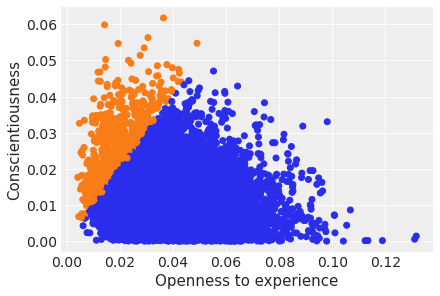

In [15]:
# Just grab first to colors from color map
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:2]
colors = [colors[1] if x > y else colors[0] for x, y in zip(sq_partial_c, sq_partial_o)]

plt.scatter(sq_partial_o, sq_partial_c, c=colors)
plt.xlabel("Openness to experience")
plt.ylabel("Conscientiousness")
plt.savefig("imgs/drugs_scatter.pdf")

Probability that `o`^2 is larger than `c`^2.

In [16]:
(pcorr_samples["o"] ** 2 > pcorr_samples["c"] ** 2).mean()

<xarray.DataArray ()>
array(0.92525)

Correlation is not 0

In [17]:
np.corrcoef(sq_partial_c, sq_partial_o)[0, 1]

-0.18572252833462846

For each predictor, what is the probability that it has the largest squared partial correlation?

In [18]:
pc_df = pcorr_samples.to_dataframe()
(pc_df**2).idxmax(axis=1).value_counts() / len(pc_df.index)

a    0.98925
o    0.01075
dtype: float64

In [19]:
model.predict(idata, kind="pps")

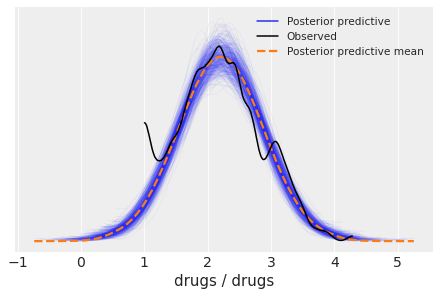

In [20]:
ax = az.plot_ppc(idata, alpha=0.05, mean=True, num_pp_samples=500)
plt.savefig("imgs/drugs_ppc.pdf")

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p formulae

Last updated: Thu May 19 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

formulae: 0.3.4

sys        : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
numpy      : 1.21.6
pandas     : 1.4.2
statsmodels: 0.13.2
matplotlib : 3.5.2
bambi      : 0.8.0
arviz      : 0.12.0

Watermark: 2.3.0

